## Chapter 22 - Nominal Predicted Variable

- [22.3.3.1 - Softmax model](#22.3.3.1---Softmax-model)
- [22.3.3.2 - Conditional logistic model](#22.3.3.2---Conditional-logistic-model)

In [3]:
# %load std_ipython_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pmc
import theano.tensor as tt

from scipy.stats import mode, beta
from scipy.special import expit
from matplotlib import gridspec
from IPython.display import Image

pd.set_option('display.notebook_repr_html', False)

%matplotlib inline
#%config InlineBackend.figure_formats = {'retina',}
plt.style.use('seaborn-white')

color = '#87ceeb'

f_dict = {'size':16}

### 22.3.3.1 - Softmax model

#### Data

In [14]:
df = pd.read_csv('data/SoftmaxRegData1.csv', dtype={'Y':'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475 entries, 0 to 474
Data columns (total 3 columns):
X1    475 non-null float64
X2    475 non-null float64
Y     475 non-null category
dtypes: category(1), float64(2)
memory usage: 8.0 KB


In [15]:
df.head()

         X1        X2  Y
0 -0.087147 -1.081342  2
1 -0.722566 -1.583863  1
2  0.179190  0.971790  3
3 -1.159752  0.502624  3
4 -0.727118  1.375704  3

In [30]:
# Standardize the data
X = df[['X1', 'X2']]
meanx = X.mean().values
scalex = X.std().values
zX = ((X-meanx)/scalex).values

#### Model (Kruschke, 2015)

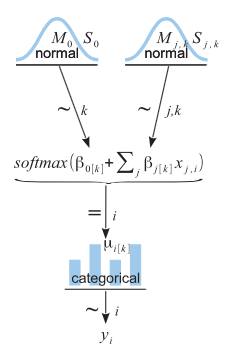

In [6]:
Image('images/fig22_4.png')

In [190]:
n_cat = df.Y.cat.categories.size

with pmc.Model() as model_softmax:
    
    zbeta0 = pmc.Normal('zbeta0', mu=0, tau=1/20**2, shape=n_cat)
    zbeta = pmc.Normal('zbeta', mu=0, tau=1/20**2, shape=(2, n_cat))
            
    mu = zbeta0 + pmc.dot(zX, zbeta)
    p = pmc.Deterministic('p', tt.nnet.softmax(mu))            
    y = pmc.Categorical('y', p=p, observed=df.Y.cat.codes.as_matrix())

In [162]:
with model_softmax:
    step = pmc.Metropolis()
    trace1 = pmc.sample(20000, step)

 [-----------------100%-----------------] 20000 of 20000 complete in 10.3 sec

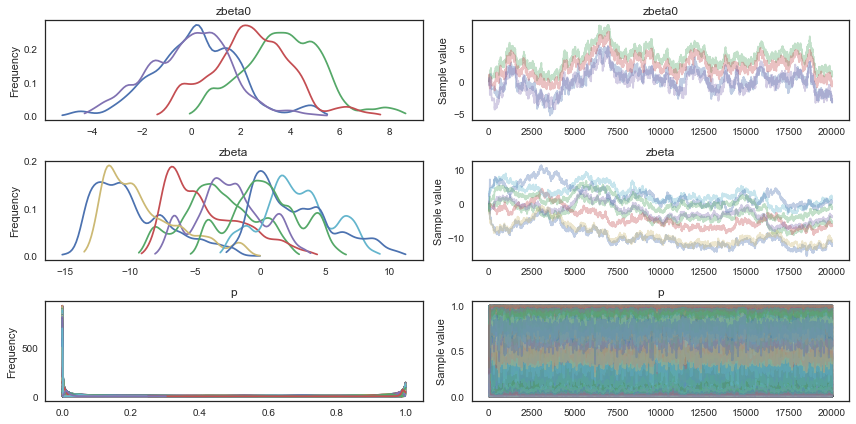

In [163]:
pmc.traceplot(trace1);

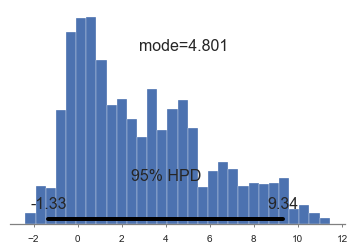

In [200]:
# Transform parameters back to original scale
#beta0 = trace1['zbeta0'] - trace1['zbeta']*meanx/scalex
#betaj = (trace1['zbeta']/scalex)
betaj = np.divide(trace1['zbeta'], np.tile(scalex, (4,1)).T)

# Category 4, Beta1
pmc.plot_posterior(betaj[:,0,3], point_estimate='mode')

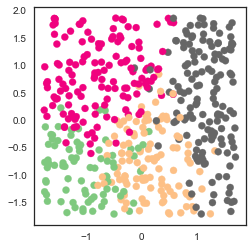

In [25]:
plt.scatter(df.X1, df.X2, c=df.Y, cmap=plt.cm.Accent)
plt.gca().set_aspect('equal')

### 22.3.3.2 - Conditional logistic model